# PCA and Dimensionality Reduction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plotting
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
# Load dataset from local file
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']
df = pd.read_csv("iris.data", names=column_names)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Data (as pandas dataframes)
print("Feature names:", X.columns.tolist())
print("Shape:", X.shape)
X.head()

Feature names: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
Shape: (150, 4)


,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


## 2. Standardization and Centering

In [3]:
# Convert to numpy array
X_np = X.values
y_np = y.values.ravel()

# Standardize
mean_vec = np.mean(X_np, axis=0)
std_vec = np.std(X_np, axis=0)
X_std = (X_np - mean_vec) / std_vec

print("Mean of standardized data (should be ~0):", np.mean(X_std, axis=0))
print("Std of standardized data (should be ~1):", np.std(X_std, axis=0))

Mean of standardized data (should be ~0): [-4.73695157e-16 -6.63173220e-16  3.31586610e-16 -2.84217094e-16]
Std of standardized data (should be ~1): [1. 1. 1. 1.]


## 3. PCA Implementation

In [4]:
# Method 1: Eigen-decomposition of Covariance Matrix
# Covariance matrix: (1 / (n-1)) * X.T @ X
cov_mat = np.cov(X_std.T)

# Eigendecomposition
eig_vals, eig_vecs = np.linalg.eigh(cov_mat)

# Sort eigenvalues and eigenvectors in descending order
idx = np.argsort(eig_vals)[::-1]
eig_vals = eig_vals[idx]
eig_vecs = eig_vecs[:, idx]

print("Eigenvalues:", eig_vals)
print("Eigenvectors shape:", eig_vecs.shape)

Eigenvalues: [2.93035378 0.92740362 0.14834223 0.02074601]
Eigenvectors shape: (4, 4)


In [5]:
# Method 2: SVD of Data Matrix
# SVD: X = U * S * Vt
U, S, Vt = np.linalg.svd(X_std)

# Eigenvalues from Singular Values: lambda_i = s_i^2 / (n-1)
n = X_std.shape[0]
eig_vals_svd = (S**2) / (n - 1)

print("Eigenvalues from SVD:", eig_vals_svd)
print("Difference between methods:", np.abs(eig_vals - eig_vals_svd).sum())

Eigenvalues from SVD: [2.93035378 0.92740362 0.14834223 0.02074601]
Difference between methods: 1.5092094240998222e-15


## 4. Projection

In [6]:
k = 2
top_k_vecs = eig_vecs[:, :k]

# Project data: Z = X_std @ W
X_pca = X_std @ top_k_vecs

print("Projected data shape:", X_pca.shape)

Projected data shape: (150, 2)


## 5. Visualization
### Scree Plot

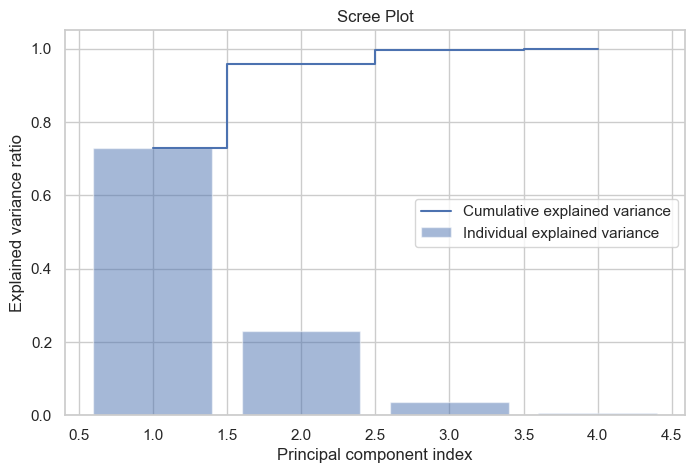

In [7]:
tot = sum(eig_vals)
var_exp = [(i / tot) for i in eig_vals]
cum_var_exp = np.cumsum(var_exp)

plt.figure(figsize=(8, 5))
plt.bar(range(1, len(var_exp)+1), var_exp, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(var_exp)+1), cum_var_exp, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.title('Scree Plot')
plt.show()

### 2D Scatter Plot

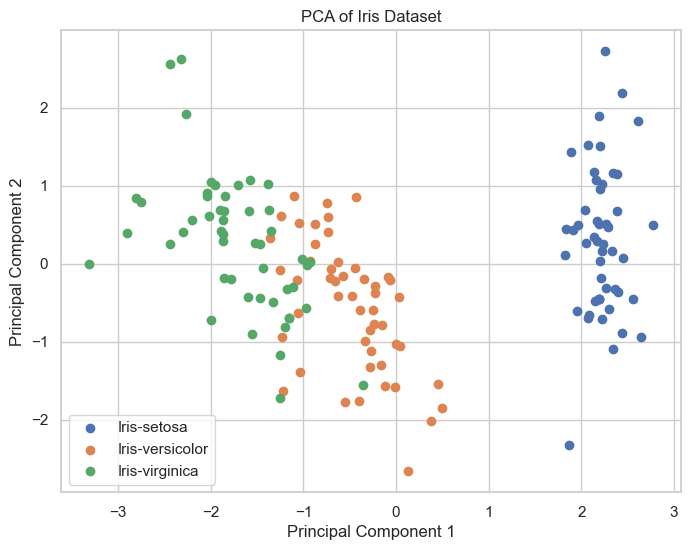

In [8]:
plt.figure(figsize=(8, 6))
for target in np.unique(y_np):
    plt.scatter(X_pca[y_np == target, 0], X_pca[y_np == target, 1], label=target)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.title('PCA of Iris Dataset')
plt.show()

## 6. Analysis & Conditioning
Condition number of the covariance matrix.

In [9]:
cond_num = np.linalg.cond(cov_mat)
print(f"Condition number of Covariance Matrix: {cond_num:.4f}")

# Interpretation of components (Loadings)
loadings = pd.DataFrame(eig_vecs[:, :2], columns=['PC1', 'PC2'], index=X.columns)
print("\nLoadings (Contribution of each feature to PCs):")
print(loadings)

Condition number of Covariance Matrix: 141.2490

Loadings (Contribution of each feature to PCs):
                   PC1       PC2
sepal_length -0.522372  0.372318
sepal_width   0.263355  0.925556
petal_length -0.581254  0.021095
petal_width  -0.565611  0.065416


## 7. Extensions
### Iterative PCA (Power Iteration)
Finding the first principal component using Power Iteration.

In [10]:
def power_iteration(A, num_simulations=100):
    # Ideally choose a random vector
    # To ensure reproducibility, we can seed or pick a fixed one
    b_k = np.random.rand(A.shape[1])

    for _ in range(num_simulations):
        # calculate the matrix-by-vector product Ab
        b_k1 = np.dot(A, b_k)

        # calculate the norm
        b_k1_norm = np.linalg.norm(b_k1)

        # re normalize the vector
        b_k = b_k1 / b_k1_norm

    return b_k

# Apply to Covariance Matrix
pc1_iterative = power_iteration(cov_mat)

print("First PC (Iterative):", pc1_iterative)
print("First PC (Eigen-decomp):", eig_vecs[:, 0])

# Note: Signs might be flipped, which is valid in PCA
dot_prod = np.dot(pc1_iterative, eig_vecs[:, 0])
print(f"Dot product: {dot_prod:.4f}")

First PC (Iterative): [ 0.52237162 -0.26335492  0.58125401  0.56561105]
First PC (Eigen-decomp): [-0.52237162  0.26335492 -0.58125401 -0.56561105]
Dot product: -1.0000


### Noise Reduction
Add noise, project to lower dimension, and reconstruct.

MSE (Original vs Noisy): 0.2440
MSE (Original vs Reconstructed): 0.1769


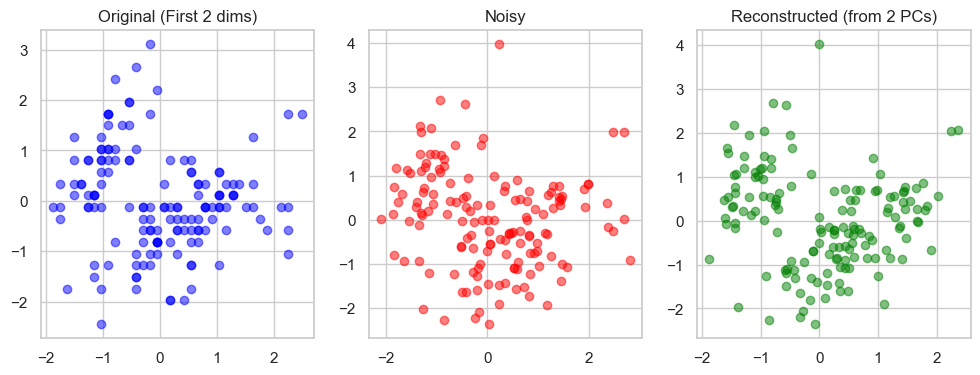

In [11]:
# Add Gaussian noise
noise = np.random.normal(0, 0.5, X_std.shape)
X_noisy = X_std + noise

# Perform PCA on noisy data
U_n, S_n, Vt_n = np.linalg.svd(X_noisy)

# Reconstruct using top 2 components
k = 2
X_reconstructed = U_n[:, :k] @ np.diag(S_n[:k]) @ Vt_n[:k, :]

# Calculate error
mse_noisy = np.mean((X_std - X_noisy)**2)
mse_recon = np.mean((X_std - X_reconstructed)**2)

print(f"MSE (Original vs Noisy): {mse_noisy:.4f}")
print(f"MSE (Original vs Reconstructed): {mse_recon:.4f}")

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.scatter(X_std[:, 0], X_std[:, 1], c='blue', alpha=0.5)
plt.title("Original (First 2 dims)")

plt.subplot(1, 3, 2)
plt.scatter(X_noisy[:, 0], X_noisy[:, 1], c='red', alpha=0.5)
plt.title("Noisy")

plt.subplot(1, 3, 3)
plt.scatter(X_reconstructed[:, 0], X_reconstructed[:, 1], c='green', alpha=0.5)
plt.title("Reconstructed (from 2 PCs)")
plt.show()